<a href="https://colab.research.google.com/github/RyanChen12035/capstone/blob/main/two_tower_target_training_BERT_TSMC_IT_BSID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.8.0 --quiet
!pip install transformers==4.15.0 --quiet
!pip install scikit-learn --quiet
!pip install faiss-gpu transformers torch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 69.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.8.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()
import sklearn as sk
import os
from nltk.data import find
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
import re

In [ ]:
from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


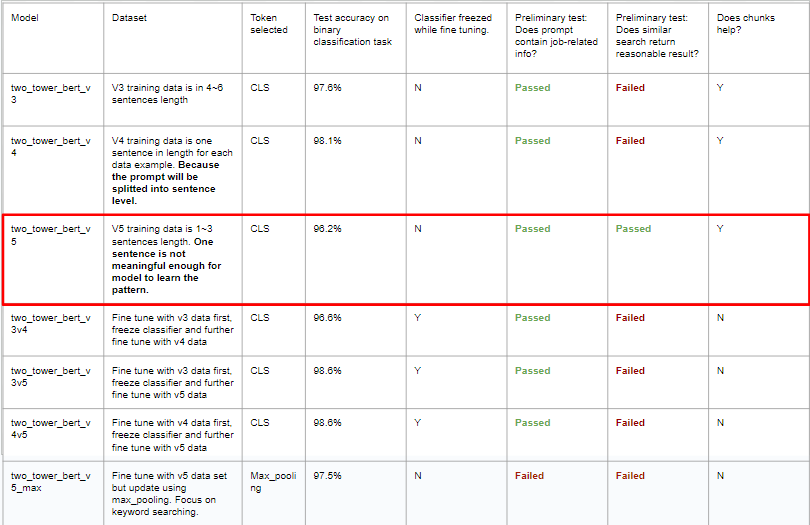

In [ ]:
from tensorflow.keras.models import load_model

custom_objects = {'TFBertModel': TFBertModel}
model_v3data = load_model('./drive/MyDrive/two_tower_bert.h5', custom_objects=custom_objects)

In [ ]:
model_v3data.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

In [ ]:
# Freeze all layers first
for layer in model_v3data.layers:
    layer.trainable = False
# turn on BERT model to trainable
bert_layer = model_v3data.get_layer('tf_bert_model')
bert_layer.trainable = True

# Check layers' trainable status
for layer in model_v3data.layers:
    print(layer.name, layer.trainable)

input_ids False
attention_mask False
token_type_ids False
tf_bert_model True
tf.__operators__.getitem False
dropout_37 False
dense False
dense_1 False


Freeze the classifier and use new data to further fine tune the BERT model. Try to make embedding space more effective for the vector database.

In [ ]:
# training data v4
df = pd.read_csv("./job_PII_diagnosis_4.csv", error_bad_lines=False)
df.head(2)

<ipython-input-7-fb8b147ff272>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("./job_PII_diagnosis_4.csv", error_bad_lines=False)


,prompt,related_to_job
0,I am doing ASP.net Developer Job opportunity a...,1
1,I am doing Customer Service Technical Speciali...,1


In [ ]:
# data split
X_train, X_test, y_train, y_test = train_test_split(df['prompt'], df['related_to_job'], test_size=0.2, random_state=42)

In [ ]:
#allow us to get the hidden layer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# bert_model = TFBertModel.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
X_train_list = X_train.apply(lambda x: x.replace('\xa0', ' ')).tolist()
X_val_list = X_test.apply(lambda x: x.replace('\xa0', ' ')).tolist()

# train
bert_train_tokenized = bert_tokenizer(X_train_list,
    max_length=128,
    truncation=True,
    padding='max_length',
    return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
    bert_train_tokenized.token_type_ids,
    bert_train_tokenized.attention_mask]
bert_train_labels = np.array(y_train)

# valdation
bert_val_tokenized = bert_tokenizer(X_val_list,
    max_length=128,
    truncation=True,
    padding='max_length',
    return_tensors='tf')
bert_val_inputs = [bert_val_tokenized.input_ids,
    bert_val_tokenized.token_type_ids,
    bert_val_tokenized.attention_mask]
bert_val_labels = np.array(y_test)

In [ ]:
print(X_train_list[0])
print(bert_train_labels[0])

As Jose, a student at Johnnyfurt Higher Institute, I have learned the importance of time management and organization through my academic journey. With my student ID number DNM7052, I have had the opportunity to engage in various lI am doing H1B SPONSOR FOR L1/L2/OPT at US, NY, New York  
1


In [ ]:
# freeze the classifier and train the BERT model only to get the embeddings

history_cls_bert= model_v3data.fit(bert_train_inputs,
                                  bert_train_labels,
                                  epochs=1, #2
                                  batch_size=16, #8
                                  validation_data=(bert_val_inputs, bert_val_labels))

#22/118 loss: 0.1622 - accuracy: 0.9784
#58/118 loss: 0.1037 - accuracy: 0.9817
#83/118 loss: 0.0963 - accuracy: 0.9799

118/118 [==============================] - 1890s 16s/step - loss: 0.0757 - accuracy: 0.9836 - val_loss: 0.3105 - val_accuracy: 0.9576


In [ ]:
model_v3data.save('./two_tower_bert_freezeclassifer.h5')

In [ ]:
model_v3data.save('./drive/MyDrive/two_tower_bert_freezeclassifer.h5')